CIFAR-10 Data Loading and Activation Functions

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

np.random.seed(951)
encoder = OneHotEncoder(sparse=False)

def load_data(file_name):
    """Adapted from the dataset website"""
    import pickle

    file_path = "/Users/supersam1995/Desktop/DD2424/datasets/cifar-10-batches-py/" + file_name

    with open(file_path, "rb") as file_obj:
        data_dict = pickle.load(file_obj, encoding="bytes")
    return data_dict

def rectified_linear_unit(input_value):
    return np.maximum(0, input_value)

def normalized_exponential(input_value):
    exp_values = np.exp(input_value)
    return exp_values / np.sum(exp_values, axis=0)


Cyclical Learning Rate Scheduler Implementation

In [30]:
class CyclicalLearningRate:
    def __init__(self, min_lr, max_lr, total_epochs, step_size):
        import math

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_epochs = total_epochs
        self.step_multiplier = 2
        self.cycle_multiplier = 3
        self.step_duration = self.step_multiplier * math.floor(step_size)
        self.time = 2 * self.cycle_multiplier * self.step_duration
        self.current_cycle = 1

    def __call__(self):
        self.time += 1

        # Check if we are in a new cycle
        if self.time > 2 * (self.cycle_multiplier + 1) * self.step_duration:
            self.cycle_multiplier += 1
            self.current_cycle += 1

        if (
            self.time >= 2 * self.cycle_multiplier * self.step_duration
        ) and (
            self.time <= (2 * self.cycle_multiplier + 1) * self.step_duration
        ):
            lr = self.min_lr + 1 / self.step_duration * (
                self.time - 2 * self.cycle_multiplier * self.step_duration
            ) * (self.max_lr - self.min_lr)
            return lr

        elif (
            self.time >= (2 * self.cycle_multiplier + 1) * self.step_duration
        ) and (
            self.time <= 2 * (self.cycle_multiplier + 1) * self.step_duration
        ):
            lr = self.max_lr - 1 / self.step_duration * (
                self.time - (2 * self.cycle_multiplier + 1) * self.step_duration
            ) * (self.max_lr - self.min_lr)
            return lr

        else:
            raise ValueError("Issue in cyclical learning rate calculation")


Lambda Search and Data Shuffling Functions

In [31]:
def generate_lambda_range(lower_limit, upper_limit):
    import numpy as np

    return np.logspace(lower_limit, upper_limit, num=10, base=10)

def refine_lambda_search(final_lambda):
    import numpy as np

    return np.linspace(
        final_lambda - final_lambda * 1e-1, final_lambda + final_lambda * 1e-1, num=10
    )

def randomize_data_order(data_x, data_y, labels):
    import numpy as np

    idx = np.arange(data_x.shape[1])
    np.random.shuffle(idx)
    return data_x[:, idx], data_y[:, idx], labels[idx]


Loading and Preprocessing CIFAR-10 Dataset

In [32]:
def load_dataset():
    data_partitions = {
        "train": "data_batch_1",
        "test": "test_batch",
        "val": "data_batch_2",
    }

    for key, file in data_partitions.items():
        data = load_data(file)

        num_samples = len(data[b"data"])
        X = np.array(data[b"data"]).T
        Y = encoder.fit_transform(np.array(data[b"labels"]).reshape(-1, 1)).T
        y = np.array(data[b"labels"])

        data_partitions[key] = [X, Y, y]

    preprocess_data(data_partitions)

    return data_partitions

def load_full_dataset():
    data_partitions = {
        "train": ["data_batch_1", "data_batch_3", "data_batch_4", "data_batch_5"],
        "test": "test_batch",
        "val": "data_batch_2",
    }

    for key, file in data_partitions.items():
        X, Y, y = [], [], []
        if isinstance(file, list):
            for fi in file:
                data = load_data(fi)
                num_samples = len(data[b"data"])
                X.append(np.array(data[b"data"]).T)
                Y.append(
                    encoder.fit_transform(np.array(data[b"labels"]).reshape(-1, 1)).T
                )
                y.append(np.array(data[b"labels"]))
            X = np.concatenate(X, axis=1)
            Y = np.concatenate(Y, axis=1)
            y = np.concatenate(y, axis=0)

        else:
            data = load_data(file)

            num_samples = len(data[b"data"])
            X = np.array(data[b"data"]).T
            Y = encoder.fit_transform(np.array(data[b"labels"]).reshape(-1, 1)).T
            y = np.array(data[b"labels"])

        data_partitions[key] = [X, Y, y]

    preprocess_data(data_partitions)

    return data_partitions

def preprocess_data(data_partitions):
    mean_X = np.mean(data_partitions["train"][0], axis=1).reshape(-1, 1)
    std_X = np.std(data_partitions["train"][0], axis=1).reshape(-1, 1)

    for key in data_partitions.keys():
        data_partitions[key][0] = (data_partitions[key][0] - mean_X) / std_X

    return data_partitions


Classifier Evaluation, Loss, Accuracy, and Gradient Calculations

In [33]:
def softmax(x):
    import numpy as np

    return np.exp(x) / np.sum(np.exp(x), axis=0)

def calculate_output(X, W1, W2, B1, B2):
    S1 = W1 @ X + B1
    H = rectified_linear_unit(S1)
    S = W2 @ H + B2
    P = softmax(S)
    return P, H

def compute_loss(X, Y, W1, W2, B1, B2, lambda_val):
    P, _ = calculate_output(X, W1, W2, B1, B2)
    num_samples = X.shape[1]
    loss = -np.sum(Y * np.log(P)) / num_samples
    regularization = lambda_val * (np.sum(W1**2) + np.sum(W2**2)) / 2
    return loss + regularization

def calculate_accuracy(X, y, W1, W2, B1, B2):
    P, _ = calculate_output(X, W1, W2, B1, B2)
    y_predicted = np.argmax(P, axis=0)
    return np.sum(y_predicted == y) / len(y)

def calculate_gradient(X, Y, W1, W2, B1, B2, lambda_val):
    num_samples = X.shape[1]
    P, H = calculate_output(X, W1, W2, B1, B2)

    G = -(Y - P)
    gradient_W2 = np.matmul(G, H.T) / num_samples + 2 * lambda_val * W2
    gradient_B2 = np.sum(G, axis=1).reshape(-1, 1) / num_samples

    G = np.matmul(W2.T, G)
    G[H <= 0.0] = 0.0
    gradient_W1 = np.matmul(G, X.T) / num_samples + 2 * lambda_val * W1
    gradient_B1 = np.sum(G, axis=1).reshape(-1, 1) / num_samples

    return gradient_W1, gradient_W2, gradient_B1, gradient_B2

def compute_numerical_gradient(X, Y, W1, W2, B1, B2, lambda_val, epsilon=1e-6):
    grad_W1 = np.zeros(W1.shape)
    grad_W2 = np.zeros(W2.shape)
    grad_B1 = np.zeros(B1.shape)
    grad_B2 = np.zeros(B2.shape)

    cost = compute_loss(X, Y, W1, W2, B1, B2, lambda_val)

    for i in range(len(B1)):
        B1[i] += epsilon
        cost2 = compute_loss(X, Y, W1, W2, B1, B2, lambda_val)
        grad_B1[i] = (cost2 - cost) / epsilon
        B1[i] -= epsilon

    for i in range(len(B2)):
        B2[i] += epsilon
        cost2 = compute_loss(X, Y, W1, W2, B1, B2, lambda_val)
        grad_B2[i] = (cost2 - cost) / epsilon
        B2[i] -= epsilon

    for i in range(len(W1)):
        for j in range(len(W1[0])):
            W1[i][j] += epsilon
            cost2 = compute_loss(X, Y, W1, W2, B1, B2, lambda_val)
            grad_W1[i][j] = (cost2 - cost) / epsilon
            W1[i][j] -= epsilon

    for i in range(len(W2)):
        for j in range(len(W2[0])):
            W2[i][j] += epsilon
            cost2 = compute_loss(X, Y, W1, W2, B1, B2, lambda_val)
            grad_W2[i][j] = (cost2 - cost) / epsilon
            W2[i][j] -= epsilon

    return grad_W1, grad_W2, grad_B1, grad_B2


def compare_gradient_values(X, Y, W1, W2, B1, B2, lambda_val):
    grad_W1, grad_W2, grad_B1, grad_B2 = calculate_gradient(X, Y, W1, W2, B1, B2, lambda_val)
    grad_W1_num, grad_W2_num, grad_B1_num, grad_B2_num = compute_numerical_gradient(
        X, Y, W1, W2, B1, B2, lambda_val
    )

    print("grad_W1: ", np.max(np.abs(grad_W1 - grad_W1_num)))
    print("grad_W2: ", np.max(np.abs(grad_W2 - grad_W2_num)))
    print("grad_B1: ", np.max(np.abs(grad_B1 - grad_B1_num)))
    print("grad_B2: ", np.max(np.abs(grad_B2 - grad_B2_num)))


Training, Updating Weights, and Plotting Loss and Accuracy

In [34]:
def apply_update(weights1, weights2, bias1, bias2, grad_w1, grad_w2, grad_b1, grad_b2, learning_rate):
    weights1 -= learning_rate * grad_w1
    weights2 -= learning_rate * grad_w2
    bias1 -= learning_rate * grad_b1
    bias2 -= learning_rate * grad_b2
    return weights1, weights2, bias1, bias2

def train_model(weights1, weights2, bias1, bias2, dataset, min_lr, max_lr, regularization, num_epochs):
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []
    X_train, Y_train, y_train = dataset["train"]
    X_val, Y_val, y_val = dataset["val"]
    batch_size = 100
    num_steps = X_train.shape[1] / batch_size

    clr = CyclicalLearningRate(min_lr, max_lr, num_epochs, num_steps)
    lr = min_lr

    while clr.current_cycle < 3:
        # Randomize the data
        X_train, Y_train, y_train = randomize_data_order(X_train, Y_train, y_train)

        for batch_idx in range(int(num_steps)):
            X_batch = X_train[:, batch_idx * batch_size : (batch_idx + 1) * batch_size]
            Y_batch = Y_train[:, batch_idx * batch_size : (batch_idx + 1) * batch_size]

            grad_w1, grad_w2, grad_b1, grad_b2 = calculate_gradient(
                X_batch, Y_batch, weights1, weights2, bias1, bias2, regularization
            )
            weights1, weights2, bias1, bias2 = apply_update(
                weights1, weights2, bias1, bias2, grad_w1, grad_w2, grad_b1, grad_b2, lr
            )

            lr = clr()

        training_loss.append(compute_loss(X_train, Y_train, weights1, weights2, bias1, bias2, regularization))
        training_accuracy.append(calculate_accuracy(X_train, y_train, weights1, weights2, bias1, bias2))
        validation_loss.append(compute_loss(X_val, Y_val, weights1, weights2, bias1, bias2, regularization))
        validation_accuracy.append(calculate_accuracy(X_val, y_val, weights1, weights2, bias1, bias2))

        #print(f"Training loss: {training_loss[-1]:.3f}")
        #print(f"Training accuracy: {training_accuracy[-1]:.3f}")
        #print(f"Validation loss: {validation_loss[-1]:.3f}")
        #print(f"Validation accuracy: {validation_accuracy[-1]:.3f}")

    return (
        weights1,
        weights2,
        bias1,
        bias2,
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

def visualize_loss_accuracy(train_loss, train_accuracy, val_loss, val_accuracy):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="train")
    plt.plot(val_loss, label="val")
    plt.title("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label="train")
    plt.plot(val_accuracy, label="val")
    plt.title("Accuracy")
    plt.legend()
    #add untis to the axis
    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")

    plt.savefig("loss_accuracy_plot.png")
    plt.show()


Top 3 Lambdas with the highest accuracy
Lambda: 0.004641588833612777 Accuracy: 0.5189
Lambda: 2.782559402207126e-05 Accuracy: 0.5143
Lambda: 0.0016681005372000592 Accuracy: 0.514


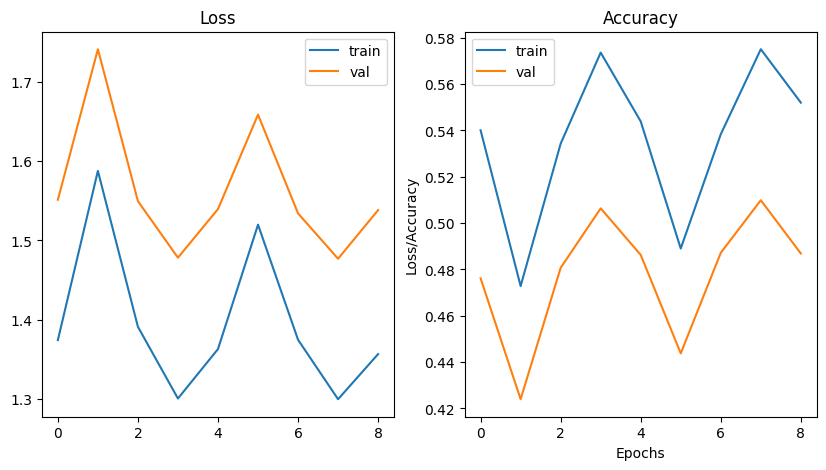

In [35]:
if __name__ == "__main__":
    initial_w1 = np.random.normal(0, 0.01, (50, 3072))
    initial_w2 = np.random.normal(0, 0.01, (10, 50))
    initial_b1 = np.zeros((50, 1))
    initial_b2 = np.zeros((10, 1))

    data_splits = load_full_dataset()

    min_lr = 1e-5
    max_lr = 1e-1
    num_epochs = 500

    low_lambda = -5
    high_lambda = -1
    lambdas = generate_lambda_range(low_lambda, high_lambda)
    optimal_lambda = 0
    best_accuracy = float("-inf")
    lambda_accuracy = {}
    lambda_accuracy[0] = float("-inf")

    for lambda_val in lambdas:
        #print(f"Grid Search Lambda: {lambda_val}")
        (
            final_w1,
            final_w2,
            final_b1,
            final_b2,
            train_loss,
            train_accuracy,
            val_loss,
            val_accuracy,
        ) = train_model(initial_w1, initial_w2, initial_b1, initial_b2, data_splits, min_lr, max_lr, lambda_val, num_epochs)

        lambda_accuracy[lambda_val] = np.max(val_accuracy)

    optimal_lambda = max(lambda_accuracy, key=lambda_accuracy.get)

    #print(f"Optimal Lambda: {optimal_lambda}")
    refined_lambda_accuracy = {}
    refined_lambda_accuracy[0] = float("-inf")

    refined_lambdas = refine_lambda_search(optimal_lambda)
    for lambda_val in refined_lambdas:
        #print(f"Fine Search Lambda: {lambda_val}")
        (
            final_w1,
            final_w2,
            final_b1,
            final_b2,
            train_loss,
            train_accuracy,
            val_loss,
            val_accuracy,
        ) = train_model(initial_w1, initial_w2, initial_b1, initial_b2, data_splits, min_lr, max_lr, lambda_val, num_epochs)

        refined_lambda_accuracy[lambda_val] = np.max(val_accuracy)

    best_refined_lambda = max(refined_lambda_accuracy, key=refined_lambda_accuracy.get)

    # Final training with the best refined lambda
    #print(f"Best Refined Lambda: {best_refined_lambda}")
    (
        final_w1,
        final_w2,
        final_b1,
        final_b2,
        train_loss,
        train_accuracy,
        val_loss,
        val_accuracy,
    ) = train_model(
        initial_w1, initial_w2, initial_b1, initial_b2, data_splits, min_lr, max_lr, best_refined_lambda, num_epochs
    )

    # Evaluate the model
    X_test, Y_test, y_test = data_splits["test"]
    test_loss = compute_loss(
        X_test, Y_test, final_w1, final_w2, final_b1, final_b2, lambda_val
    )
    test_accuracy = calculate_accuracy(X_test, y_test, final_w1, final_w2, final_b1, final_b2)
    #print(f"Test loss: {test_loss:.3f}")
    #print(f"Test accuracy: {test_accuracy:.3f}")

    # Print the top 3 lambdas with the highest accuracy
    print("Top 3 Lambdas with the highest accuracy")
    for i in range(3):
        best_lambda = max(lambda_accuracy, key=lambda_accuracy.get)
        print(f"Lambda: {best_lambda} Accuracy: {lambda_accuracy[best_lambda]}")
        lambda_accuracy.pop(best_lambda)

    visualize_loss_accuracy(train_loss, train_accuracy, val_loss, val_accuracy)
    
